# PreTrain

In [1]:
from model.sswae_dev2_1 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 8

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.349
[2] loss: 0.212
[3] loss: 0.052
[4] loss: 0.028
[5] loss: 0.019
[6] loss: 0.013
[7] loss: 0.011
[8] loss: 0.010
[9] loss: 0.005
[10] loss: 0.007
[11] loss: 0.007
[12] loss: 0.006
[13] loss: 0.005
[14] loss: 0.003
[15] loss: 0.003
[16] loss: 0.005
[17] loss: 0.002
[18] loss: 0.006
[19] loss: 0.003
[20] loss: 0.003


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 8])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

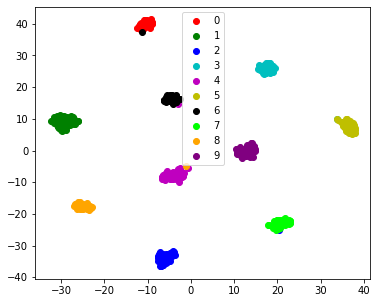

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

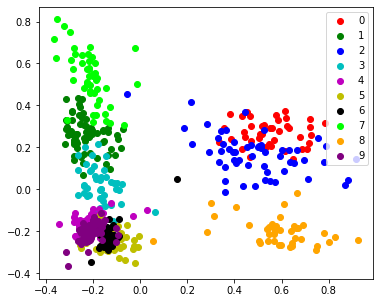

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)
covs = np.zeros((10, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [12]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[ 0.4849, -0.2541,  0.4987, -0.1834, -0.2235, -0.1332, -0.1278, -0.2028,
          0.5908, -0.2270],
        [-0.3029, -0.0146, -0.2818,  0.1170,  0.3021, -0.1969, -0.3074,  0.1061,
          0.2932,  0.3346],
        [ 0.2432,  0.2868,  0.1644,  0.0385, -0.1638, -0.2405, -0.2084,  0.5195,
         -0.2146, -0.1994],
        [ 0.3175,  0.5185, -0.2124, -0.1763, -0.1920, -0.1465,  0.3911, -0.2315,
         -0.0547,  0.2870],
        [-0.2540,  0.2809,  0.3079, -0.2276,  0.3510,  0.3682, -0.1065, -0.1489,
         -0.0941, -0.2063],
        [ 0.3217,  0.0796, -0.0595,  0.5437, -0.0511,  0.3501, -0.0939, -0.1221,
         -0.0936, -0.1234],
        [-0.0604, -0.5168,  0.1080, -0.2126,  0.1332, -0.3552,  0.3566, -0.3711,
         -0.4439, -0.0184],
        [ 0.3419, -0.2057, -0.1873, -0.3093, -0.2044,  0.3864, -0.2836,  0.3426,
         -0.1870,  0.3609]])

In [13]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}.pt')

In [14]:
w2 = torch.tensor((covs.T / (cs - 1)).T)

In [15]:
for i in range(10):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [16]:
f2 = nn.ConvTranspose2d(10, 1, y_dim, bias=False)
f2.weight.data = w2.view(10,1,y_dim,y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}.pt')

# Train

In [3]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_1_11.cfg')

['./config/sswae_dev2_1_11.cfg']

In [4]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 6
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 8
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [01/80]  loss: 2.313168e-01  D: 6.886512e-01  D2: 4.190437e-02  D3: 2.780426e-03
test loss: 1.676876e-01  D: 6.910862e-01  D2: 1.624247e-02  D3: 5.876981e-03


[default |INFO|model.py:1280] [02/80]  loss: 1.584243e-01  D: 6.943619e-01  D2: 1.189023e-02  D3: 6.570266e-03
test loss: 1.451457e-01  D: 6.804515e-01  D2: 7.939816e-03  D3: 5.457607e-03


[default |INFO|model.py:1280] [03/80]  loss: 1.261233e-01  D: 6.934016e-01  D2: 4.123972e-03  D3: 6.034661e-03
test loss: 1.019805e-01  D: 6.887777e-01  D2: 1.562281e-03  D3: 6.050334e-03


[default |INFO|model.py:1280] [04/80]  loss: 1.105584e-01  D: 6.978686e-01  D2: 5.184015e-04  D3: 7.933226e-03
test loss: 9.536755e-02  D: 6.908986e-01  D2: -8.962059e-04  D3: 6.550419e-03


[default |INFO|model.py:1280] [05/80]  loss: 8.915960e-02  D: 6.938202e-01  D2: -1.865400e-03  D3: 8.720435e-03
test loss: 9.707482e-02  D: 6.882651e-01  D2: -1.422195e-03  D3: 1.456020e-02


[default |INFO|model.py:1280] [06/80]  loss: 8.502446e-02  D: 6.939286e-01  D2: -2.578071e-03  D3: 1.341186e-02
test loss: 7.614333e-02  D: 6.963559e-01  D2: -1.727953e-03  D3: 1.163243e-02


[default |INFO|model.py:1280] [07/80]  loss: 8.048770e-02  D: 6.954039e-01  D2: -3.125057e-03  D3: 1.327995e-02
test loss: 7.882871e-02  D: 7.220830e-01  D2: -3.308706e-03  D3: 1.448197e-02


[default |INFO|model.py:1280] [08/80]  loss: 7.614675e-02  D: 6.934951e-01  D2: -3.624778e-03  D3: 1.292096e-02
test loss: 6.767304e-02  D: 6.899726e-01  D2: -3.249483e-03  D3: 1.166628e-02


[default |INFO|model.py:1280] [09/80]  loss: 7.118451e-02  D: 6.944434e-01  D2: -3.648643e-03  D3: 1.435341e-02
test loss: 6.840036e-02  D: 7.057666e-01  D2: -4.071465e-03  D3: 1.497986e-02


[default |INFO|model.py:1280] [10/80]  loss: 6.636030e-02  D: 6.932866e-01  D2: -4.310366e-03  D3: 1.471009e-02
test loss: 6.349664e-02  D: 6.828671e-01  D2: -4.915228e-03  D3: 1.459345e-02


[default |INFO|model.py:1280] [11/80]  loss: 6.384238e-02  D: 6.941157e-01  D2: -4.973493e-03  D3: 1.402391e-02
test loss: 6.373774e-02  D: 6.848639e-01  D2: -4.635582e-03  D3: 1.321045e-02


[default |INFO|model.py:1280] [12/80]  loss: 6.268093e-02  D: 6.938592e-01  D2: -4.999517e-03  D3: 1.382275e-02
test loss: 6.074067e-02  D: 6.755205e-01  D2: -5.478210e-03  D3: 1.507799e-02


[default |INFO|model.py:1280] [13/80]  loss: 6.100156e-02  D: 6.930105e-01  D2: -5.665611e-03  D3: 1.415281e-02
test loss: 6.128684e-02  D: 7.130152e-01  D2: -5.954857e-03  D3: 1.463918e-02


[default |INFO|model.py:1280] [14/80]  loss: 6.039743e-02  D: 6.944555e-01  D2: -5.668190e-03  D3: 1.352568e-02
test loss: 5.857107e-02  D: 6.913696e-01  D2: -5.930386e-03  D3: 1.329587e-02


[default |INFO|model.py:1280] [15/80]  loss: 6.341369e-02  D: 6.947421e-01  D2: -5.715114e-03  D3: 1.303114e-02
test loss: 6.408755e-02  D: 6.834891e-01  D2: -5.943842e-03  D3: 1.323173e-02


[default |INFO|model.py:1280] [16/80]  loss: 6.143460e-02  D: 6.943465e-01  D2: -5.877175e-03  D3: 1.296347e-02
test loss: 5.837876e-02  D: 6.904779e-01  D2: -5.560122e-03  D3: 1.409925e-02


[default |INFO|model.py:1280] [17/80]  loss: 5.918809e-02  D: 6.941737e-01  D2: -6.246684e-03  D3: 1.344142e-02
test loss: 5.593242e-02  D: 7.041616e-01  D2: -6.838646e-03  D3: 1.479090e-02


[default |INFO|model.py:1280] [18/80]  loss: 5.701355e-02  D: 6.938161e-01  D2: -6.254067e-03  D3: 1.309497e-02
test loss: 5.614877e-02  D: 6.931274e-01  D2: -6.851406e-03  D3: 1.201198e-02


[default |INFO|model.py:1280] [19/80]  loss: 5.623631e-02  D: 6.941316e-01  D2: -6.557452e-03  D3: 1.332240e-02
test loss: 5.613403e-02  D: 7.017047e-01  D2: -6.932869e-03  D3: 1.075739e-02


[default |INFO|model.py:1280] [20/80]  loss: 5.708724e-02  D: 6.936243e-01  D2: -6.733901e-03  D3: 1.285613e-02
test loss: 5.527132e-02  D: 6.909721e-01  D2: -6.542368e-03  D3: 1.504076e-02


[default |INFO|model.py:1280] [21/80]  loss: 5.614937e-02  D: 6.941617e-01  D2: -6.616492e-03  D3: 1.293187e-02
test loss: 5.555834e-02  D: 6.872756e-01  D2: -6.763544e-03  D3: 1.040006e-02


[default |INFO|model.py:1280] [22/80]  loss: 5.553399e-02  D: 6.945120e-01  D2: -6.668948e-03  D3: 1.288621e-02
test loss: 6.572272e-02  D: 7.101832e-01  D2: -6.608229e-03  D3: 1.213489e-02


[default |INFO|model.py:1280] [23/80]  loss: 5.412089e-02  D: 6.942146e-01  D2: -6.903397e-03  D3: 1.311185e-02
test loss: 5.472596e-02  D: 6.900907e-01  D2: -7.122002e-03  D3: 1.416809e-02


[default |INFO|model.py:1280] [24/80]  loss: 5.228484e-02  D: 6.940836e-01  D2: -7.065608e-03  D3: 1.305236e-02
test loss: 5.128922e-02  D: 6.934367e-01  D2: -7.212772e-03  D3: 1.380689e-02


[default |INFO|model.py:1280] [25/80]  loss: 5.317564e-02  D: 6.938029e-01  D2: -7.059434e-03  D3: 1.255768e-02
test loss: 5.837756e-02  D: 6.865242e-01  D2: -7.112474e-03  D3: 1.021749e-02


[default |INFO|model.py:1280] [26/80]  loss: 5.233786e-02  D: 6.945230e-01  D2: -7.315413e-03  D3: 1.321654e-02
test loss: 5.421859e-02  D: 6.573737e-01  D2: -7.153320e-03  D3: 1.369040e-02


[default |INFO|model.py:1280] [27/80]  loss: 5.259117e-02  D: 6.933862e-01  D2: -7.490228e-03  D3: 1.285497e-02
test loss: 5.130990e-02  D: 6.754581e-01  D2: -6.687298e-03  D3: 1.549900e-02


[default |INFO|model.py:1280] [28/80]  loss: 4.978882e-02  D: 6.930245e-01  D2: -7.344995e-03  D3: 1.359352e-02
test loss: 4.898280e-02  D: 6.917218e-01  D2: -7.085876e-03  D3: 1.190064e-02


[default |INFO|model.py:1280] [29/80]  loss: 5.056476e-02  D: 6.946135e-01  D2: -7.388827e-03  D3: 1.310329e-02
test loss: 4.922270e-02  D: 6.948515e-01  D2: -7.849092e-03  D3: 1.518310e-02


[default |INFO|model.py:1280] [30/80]  loss: 4.919986e-02  D: 6.929478e-01  D2: -7.658822e-03  D3: 1.329395e-02
test loss: 5.044721e-02  D: 6.905524e-01  D2: -7.658482e-03  D3: 1.179294e-02


[default |INFO|model.py:1280] [31/80]  loss: 5.166307e-02  D: 6.951186e-01  D2: -7.673378e-03  D3: 1.277105e-02
test loss: 4.966937e-02  D: 7.063439e-01  D2: -7.592068e-03  D3: 1.211851e-02


[default |INFO|model.py:1280] [32/80]  loss: 4.978019e-02  D: 6.940347e-01  D2: -7.807622e-03  D3: 1.307213e-02
test loss: 5.438488e-02  D: 6.930056e-01  D2: -7.775116e-03  D3: 1.143707e-02


[default |INFO|model.py:1280] [33/80]  loss: 4.945347e-02  D: 6.935231e-01  D2: -7.836180e-03  D3: 1.320036e-02
test loss: 5.086125e-02  D: 7.170715e-01  D2: -8.204889e-03  D3: 1.202181e-02


[default |INFO|model.py:1280] [34/80]  loss: 4.753937e-02  D: 6.929709e-01  D2: -7.893275e-03  D3: 1.337309e-02
test loss: 4.853086e-02  D: 6.910920e-01  D2: -7.621193e-03  D3: 1.397343e-02


[default |INFO|model.py:1280] [35/80]  loss: 4.649017e-02  D: 6.933620e-01  D2: -8.086260e-03  D3: 1.336767e-02
test loss: 4.712943e-02  D: 6.776123e-01  D2: -8.231630e-03  D3: 1.160389e-02


[default |INFO|model.py:1280] [36/80]  loss: 4.741917e-02  D: 6.943078e-01  D2: -7.969271e-03  D3: 1.292279e-02
test loss: 4.697053e-02  D: 6.889536e-01  D2: -8.333311e-03  D3: 1.456456e-02


[default |INFO|model.py:1280] [37/80]  loss: 4.653918e-02  D: 6.928926e-01  D2: -8.192697e-03  D3: 1.322507e-02
test loss: 4.631547e-02  D: 6.787260e-01  D2: -8.397598e-03  D3: 1.292684e-02


[default |INFO|model.py:1280] [38/80]  loss: 4.569245e-02  D: 6.931529e-01  D2: -8.228828e-03  D3: 1.321759e-02
test loss: 4.808915e-02  D: 6.859099e-01  D2: -8.364639e-03  D3: 1.404164e-02


[default |INFO|model.py:1280] [39/80]  loss: 4.669697e-02  D: 6.933021e-01  D2: -8.172762e-03  D3: 1.332931e-02
test loss: 4.737437e-02  D: 7.000175e-01  D2: -8.073320e-03  D3: 1.283151e-02


[default |INFO|model.py:1280] [40/80]  loss: 4.570724e-02  D: 6.944256e-01  D2: -8.380181e-03  D3: 1.302875e-02
test loss: 4.563804e-02  D: 7.048791e-01  D2: -8.510675e-03  D3: 1.354709e-02


[default |INFO|model.py:1280] [41/80]  loss: 4.510830e-02  D: 6.932974e-01  D2: -8.386219e-03  D3: 1.316328e-02
test loss: 4.615633e-02  D: 6.859940e-01  D2: -8.481512e-03  D3: 1.314041e-02


[default |INFO|model.py:1280] [42/80]  loss: 4.543781e-02  D: 6.932438e-01  D2: -8.383770e-03  D3: 1.297996e-02
test loss: 4.498631e-02  D: 6.866833e-01  D2: -8.396702e-03  D3: 1.336019e-02


[default |INFO|model.py:1280] [43/80]  loss: 4.447506e-02  D: 6.938983e-01  D2: -8.457368e-03  D3: 1.283810e-02
test loss: 4.559002e-02  D: 6.840792e-01  D2: -8.596354e-03  D3: 1.440437e-02


[default |INFO|model.py:1280] [44/80]  loss: 4.420993e-02  D: 6.923559e-01  D2: -8.556067e-03  D3: 1.306114e-02
test loss: 4.522366e-02  D: 6.973354e-01  D2: -8.495770e-03  D3: 1.249271e-02


[default |INFO|model.py:1280] [45/80]  loss: 4.445162e-02  D: 6.934368e-01  D2: -8.549965e-03  D3: 1.288549e-02
test loss: 4.683479e-02  D: 7.098801e-01  D2: -8.709736e-03  D3: 1.118881e-02


[default |INFO|model.py:1280] [46/80]  loss: 4.398196e-02  D: 6.929009e-01  D2: -8.632108e-03  D3: 1.301391e-02
test loss: 4.738799e-02  D: 6.923437e-01  D2: -8.261051e-03  D3: 1.312835e-02


[default |INFO|model.py:1280] [47/80]  loss: 4.427352e-02  D: 6.936725e-01  D2: -8.610732e-03  D3: 1.287413e-02
test loss: 4.594332e-02  D: 7.006889e-01  D2: -8.808317e-03  D3: 1.187740e-02


[default |INFO|model.py:1280] [48/80]  loss: 4.357983e-02  D: 6.930153e-01  D2: -8.733295e-03  D3: 1.302774e-02
test loss: 4.676677e-02  D: 7.029670e-01  D2: -8.509827e-03  D3: 1.172560e-02


[default |INFO|model.py:1280] [49/80]  loss: 4.347569e-02  D: 6.933159e-01  D2: -8.673290e-03  D3: 1.297071e-02
test loss: 4.435602e-02  D: 6.932494e-01  D2: -8.871078e-03  D3: 1.269771e-02


[default |INFO|model.py:1280] [50/80]  loss: 4.399034e-02  D: 6.934311e-01  D2: -8.790905e-03  D3: 1.256660e-02
test loss: 4.344057e-02  D: 6.851732e-01  D2: -8.716917e-03  D3: 1.346460e-02


[default |INFO|model.py:1280] [51/80]  loss: 4.320165e-02  D: 6.933666e-01  D2: -8.694889e-03  D3: 1.280616e-02
test loss: 4.484077e-02  D: 6.955339e-01  D2: -8.979740e-03  D3: 1.182379e-02


[default |INFO|model.py:1280] [52/80]  loss: 4.252739e-02  D: 6.931268e-01  D2: -8.805394e-03  D3: 1.287226e-02
test loss: 4.508017e-02  D: 7.072520e-01  D2: -9.131355e-03  D3: 1.401562e-02


[default |INFO|model.py:1280] [53/80]  loss: 4.259359e-02  D: 6.931228e-01  D2: -8.901534e-03  D3: 1.267273e-02
test loss: 4.514549e-02  D: 7.069479e-01  D2: -8.853855e-03  D3: 1.458777e-02


[default |INFO|model.py:1280] [54/80]  loss: 4.414671e-02  D: 6.940434e-01  D2: -8.779151e-03  D3: 1.237706e-02
test loss: 4.714776e-02  D: 6.951180e-01  D2: -8.898001e-03  D3: 1.271092e-02


[default |INFO|model.py:1280] [55/80]  loss: 4.368891e-02  D: 6.936926e-01  D2: -8.882329e-03  D3: 1.256752e-02
test loss: 4.871355e-02  D: 6.971822e-01  D2: -8.808985e-03  D3: 1.021500e-02


[default |INFO|model.py:1280] [56/80]  loss: 4.385966e-02  D: 6.934107e-01  D2: -8.880548e-03  D3: 1.241926e-02
test loss: 4.406766e-02  D: 7.013354e-01  D2: -9.058971e-03  D3: 1.236180e-02


[default |INFO|model.py:1280] [57/80]  loss: 4.286824e-02  D: 6.931274e-01  D2: -8.967802e-03  D3: 1.264477e-02
test loss: 4.465913e-02  D: 6.915933e-01  D2: -8.972654e-03  D3: 1.322482e-02


[default |INFO|model.py:1280] [58/80]  loss: 4.274269e-02  D: 6.931321e-01  D2: -8.942383e-03  D3: 1.260162e-02
test loss: 4.420067e-02  D: 6.949951e-01  D2: -9.079742e-03  D3: 1.279704e-02


[default |INFO|model.py:1280] [59/80]  loss: 4.273415e-02  D: 6.937900e-01  D2: -9.029241e-03  D3: 1.257176e-02
test loss: 4.397418e-02  D: 7.073146e-01  D2: -9.112425e-03  D3: 1.221380e-02


[default |INFO|model.py:1280] [60/80]  loss: 4.344934e-02  D: 6.933088e-01  D2: -8.948867e-03  D3: 1.236090e-02
test loss: 4.456305e-02  D: 6.771982e-01  D2: -9.198809e-03  D3: 1.266940e-02


[default |INFO|model.py:1280] [61/80]  loss: 4.298554e-02  D: 6.936405e-01  D2: -9.064000e-03  D3: 1.239149e-02
test loss: 4.206724e-02  D: 6.963280e-01  D2: -9.285383e-03  D3: 1.279231e-02


[default |INFO|model.py:1280] [62/80]  loss: 4.157091e-02  D: 6.928694e-01  D2: -9.119167e-03  D3: 1.249288e-02
test loss: 4.289952e-02  D: 6.949710e-01  D2: -8.994875e-03  D3: 1.308939e-02


[default |INFO|model.py:1280] [63/80]  loss: 4.182143e-02  D: 6.937057e-01  D2: -9.117033e-03  D3: 1.245848e-02
test loss: 4.425630e-02  D: 6.904985e-01  D2: -8.775291e-03  D3: 1.259971e-02


[default |INFO|model.py:1280] [64/80]  loss: 4.236044e-02  D: 6.925141e-01  D2: -9.085635e-03  D3: 1.245270e-02
test loss: 4.443723e-02  D: 6.968389e-01  D2: -9.177713e-03  D3: 1.255665e-02


[default |INFO|model.py:1280] [65/80]  loss: 4.179633e-02  D: 6.937378e-01  D2: -9.144168e-03  D3: 1.248743e-02
test loss: 4.323409e-02  D: 7.048622e-01  D2: -9.318714e-03  D3: 1.289742e-02


[default |INFO|model.py:1280] [66/80]  loss: 4.108173e-02  D: 6.931184e-01  D2: -9.219297e-03  D3: 1.253378e-02
test loss: 4.392297e-02  D: 6.910186e-01  D2: -9.210873e-03  D3: 1.237744e-02


[default |INFO|model.py:1280] [67/80]  loss: 4.222917e-02  D: 6.934810e-01  D2: -9.187689e-03  D3: 1.222702e-02
test loss: 4.643637e-02  D: 6.865987e-01  D2: -8.936253e-03  D3: 1.116682e-02


[default |INFO|model.py:1280] [68/80]  loss: 4.162557e-02  D: 6.935308e-01  D2: -9.166945e-03  D3: 1.223449e-02
test loss: 4.401842e-02  D: 6.966289e-01  D2: -9.079962e-03  D3: 1.220616e-02


[default |INFO|model.py:1280] [69/80]  loss: 4.140451e-02  D: 6.931419e-01  D2: -9.221527e-03  D3: 1.226780e-02
test loss: 4.461694e-02  D: 6.918142e-01  D2: -9.356194e-03  D3: 1.203766e-02


[default |INFO|model.py:1280] [70/80]  loss: 4.160427e-02  D: 6.935503e-01  D2: -9.214797e-03  D3: 1.226877e-02
test loss: 4.448926e-02  D: 6.958394e-01  D2: -9.436293e-03  D3: 1.070423e-02


[default |INFO|model.py:1280] [71/80]  loss: 4.050509e-02  D: 6.933529e-01  D2: -9.315713e-03  D3: 1.247203e-02
test loss: 4.377993e-02  D: 6.958748e-01  D2: -9.052248e-03  D3: 1.249900e-02


[default |INFO|model.py:1280] [72/80]  loss: 4.112737e-02  D: 6.932824e-01  D2: -9.336263e-03  D3: 1.216082e-02
test loss: 4.378957e-02  D: 6.965798e-01  D2: -8.931780e-03  D3: 1.297925e-02


[default |INFO|model.py:1280] [73/80]  loss: 4.124964e-02  D: 6.934604e-01  D2: -9.324932e-03  D3: 1.225939e-02
test loss: 4.331521e-02  D: 7.027450e-01  D2: -9.260645e-03  D3: 1.126459e-02


[default |INFO|model.py:1280] [74/80]  loss: 4.104211e-02  D: 6.933026e-01  D2: -9.352918e-03  D3: 1.223288e-02
test loss: 4.359923e-02  D: 6.861580e-01  D2: -9.559708e-03  D3: 1.221000e-02


[default |INFO|model.py:1280] [75/80]  loss: 4.074274e-02  D: 6.934423e-01  D2: -9.364748e-03  D3: 1.214869e-02
test loss: 4.252526e-02  D: 6.913769e-01  D2: -9.631901e-03  D3: 1.123697e-02


[default |INFO|model.py:1280] [76/80]  loss: 4.163595e-02  D: 6.931431e-01  D2: -9.397971e-03  D3: 1.213979e-02
test loss: 4.357757e-02  D: 7.102062e-01  D2: -9.423037e-03  D3: 1.085670e-02


[default |INFO|model.py:1280] [77/80]  loss: 4.040946e-02  D: 6.934153e-01  D2: -9.415577e-03  D3: 1.222940e-02
test loss: 4.191398e-02  D: 6.940265e-01  D2: -9.443207e-03  D3: 1.134284e-02


[default |INFO|model.py:1280] [78/80]  loss: 4.060968e-02  D: 6.931233e-01  D2: -9.408875e-03  D3: 1.211283e-02
test loss: 4.148760e-02  D: 6.940662e-01  D2: -9.586926e-03  D3: 1.274553e-02


[default |INFO|model.py:1280] [79/80]  loss: 4.037679e-02  D: 6.933572e-01  D2: -9.443981e-03  D3: 1.214438e-02
test loss: 4.283851e-02  D: 6.905981e-01  D2: -9.316206e-03  D3: 1.127708e-02


[default |INFO|model.py:1280] [80/80]  loss: 4.051550e-02  D: 6.938566e-01  D2: -9.421115e-03  D3: 1.212296e-02
test loss: 4.235684e-02  D: 6.896357e-01  D2: -9.523153e-03  D3: 1.201634e-02


[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 3157.425s


# Test

In [5]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [6]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [7]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

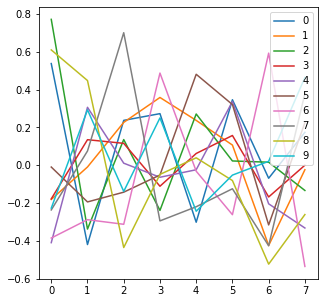

In [8]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

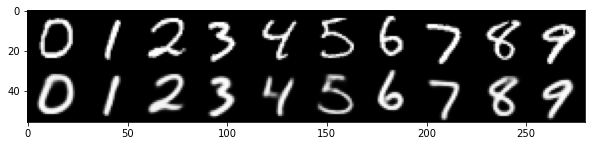

In [9]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [10]:
from XAE.sampler import gaus

exn = 5

In [11]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

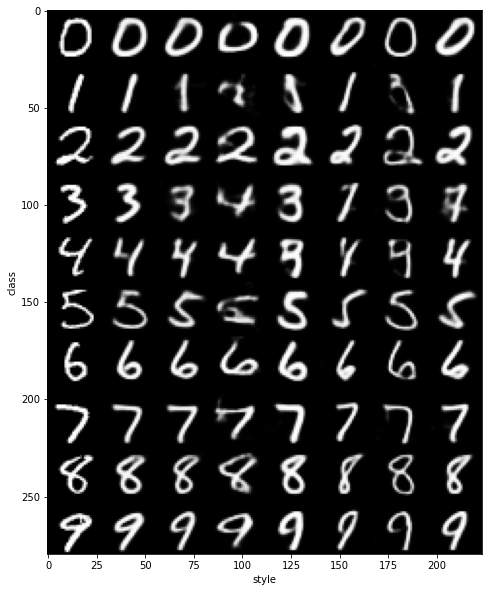

In [12]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [13]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

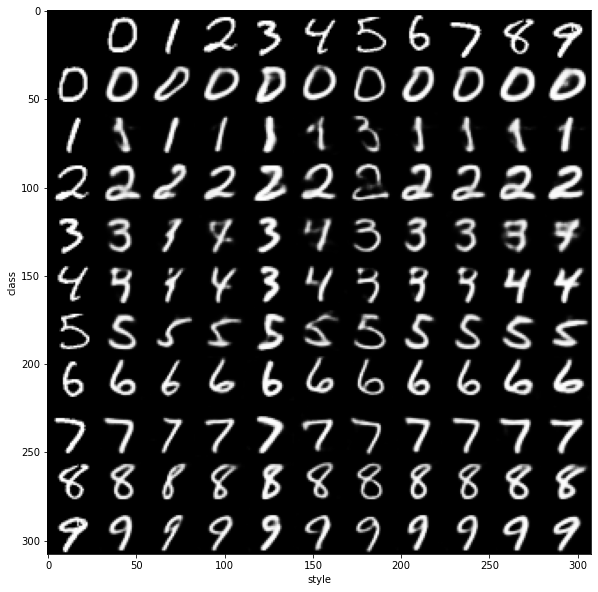

In [14]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()